### Inverse Modelling: Demonstration of parameterisation of structure and history matching
#### Showcasing LoopStructural-Flopy to address Model Structure Uncertainty

 Processing MCMC results


In [1]:
import pandas as pd
import numpy as np
import subprocess
import sys
import os
import pickle
#%load_ext autoreload
%autoreload 2
import functions
#%run ./loop_showcase_functions.ipynb  # Contains project specific functions
    
sys.path.append('../../MODFLOW_Tools')    
logfunc = lambda e: np.log10(e)

UsageError: Line magic function `%autoreload` not found.


#### Plot parameter estimates

In [2]:
nchains = 5
npars = 13
nsamples = 100
nburn = 20

fname = '../results/01/run_pars.dat'
B = np.loadtxt(fname)[:,1:]
n = int(B.shape[0]/nchains)
A = B.reshape((n, nchains, npars))


In [20]:
hk_ref = [1, 0.1, 5, 0.1] 
vk_ref = [i/10 for i in hk_ref]
ss_ref = [0.00005, 0.00005, 0.00005, 0.00005][1:]
Min = [-1, -2, logfunc(5)-1, -2, -2, -3, logfunc(0.5)-1, -3, -5, -5, -5, 0.05, -250]
Max = [1,   0, logfunc(5)+1,  0,  0, -1, logfunc(0.5)+1, -1, -4, -4, -4, 0.2,   0  ]

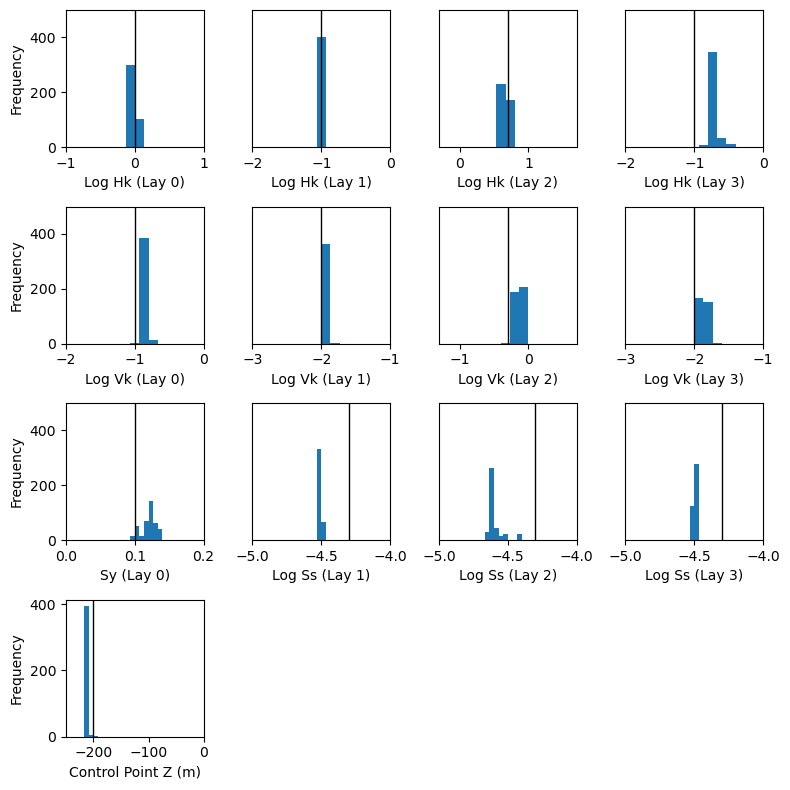

In [22]:
fig, ax = plt.subplots(4,4, figsize = (8,8))

# Hk
for i in range(4):
    ax = plt.subplot(4,4,i+1)
    ax.hist(A[nburn:,:,i].flatten(), bins=30, range = (-2,2))
    plt.axvline(logfunc(hk_ref[i]), color = 'black', lw = 1)
    ax.set_xlabel(f'Log Hk (Lay {i})')
    if i == 0: ax.set_ylabel('Frequency')
    ax.set_ylim([0,500])
    ax.set_xlim([Min[i], Max[i]])
    if i != 0: ax.set_yticks([])

# Vk        
for i in range(4):
    ax = plt.subplot(4,4,i+5)
    ax.hist(A[nburn:,:,i+4].flatten(), bins=30, range = (-2,2))
    plt.axvline(logfunc(vk_ref[i]), color = 'black', lw = 1)
    ax.set_xlabel(f'Log Vk (Lay {i})')
    if i == 0: ax.set_ylabel('Frequency')
    ax.set_ylim([0,500])
    ax.set_xlim([Min[i+4], Max[i+4]])
    if i != 0: ax.set_yticks([])
        
# Sy
ax = plt.subplot(4,4,9)
ax.hist(A[nburn:,:,-2].flatten(), bins=30, range = (0,0.2))
plt.axvline(0.1, color = 'black', lw = 1)
ax.set_xlabel('Sy (Lay 0)')
ax.set_ylabel('Frequency')
ax.set_xlim([0, 0.2])
ax.set_ylim([0,500])

#Ss
for i in range(3):
    ax = plt.subplot(4,4,i+10)
    ax.hist(A[nburn:,:,i+8].flatten(), bins=30, range = (-5,-4))
    plt.axvline(logfunc(ss_ref[i]), color = 'black', lw = 1)
    ax.set_xlabel(f'Log Ss (Lay {i+1})')
    ax.set_ylim([0,500])
    ax.set_xlim([Min[i+8], Max[i+8]])
    ax.set_yticks([])

# CPz    
ax = plt.subplot(4,4,13)    
ax.hist(A[nburn:,:,-1].flatten(), bins=30, range = (-250,0))
plt.axvline(-200, color = 'black', lw = 1)
ax.set_xlabel('Control Point Z (m)')
ax.set_ylabel('Frequency')
ax.set_xlim([-250,0])

ax = plt.subplot(4,4,14) 
ax.set_axis_off()
ax = plt.subplot(4,4,15) 
ax.set_axis_off()
ax = plt.subplot(4,4,16) 
ax.set_axis_off()
        
plt.subplots_adjust(wspace=0.5)#, hspace=0.1)    
plt.tight_layout()  
fig.savefig('../figures/figure7', dpi=450) 

### 01 Including CPz in MCMC

In [23]:
# PAST
data_set = pd.read_csv("../results/01/ref_past.csv", header=0) # Get times
df = pd.DataFrame(data_set)
times_past = df.iloc[:,0]/365 

pickleoff = open('../results/01/ref_past.pkl','rb') # Load saved observations for future
ref_past = pickle.load(pickleoff)
pickleoff.close()
ref_past = np.array(ref_past)

pickleoff = open('../results/01/hobs_past.pkl','rb') # Load saved observations for calibrated predictions
obs_past = pickle.load(pickleoff)
pickleoff.close()
obs_past = np.array(obs_past)

# FUTURE
data_set = pd.read_csv("../results/01/run_future.csv", header=0) # Get times
df = pd.DataFrame(data_set)
times_future = df.iloc[:,0]/365 

pickleoff = open('../results/01/ref_future.pkl','rb') # Load saved observations for future
ref_future = pickle.load(pickleoff)
pickleoff.close()
ref_future = np.array(ref_future)

pickleoff = open('../results/01/hobs_pred.pkl','rb') # Load saved observations for calibrated predictions
obs_future = pickle.load(pickleoff)
pickleoff.close()
obs_future = np.array(obs_future)

print('ref_past shape', ref_past.shape) 
print('obs_past shape', obs_past.shape) 

print('ref_future shape', ref_future.shape) 
print('obs_future shape', obs_future.shape) 

ref_past shape (5, 3, 12)
obs_past shape (112, 5, 3, 12)
ref_future shape (5, 3, 30)
obs_future shape (112, 5, 3, 30)


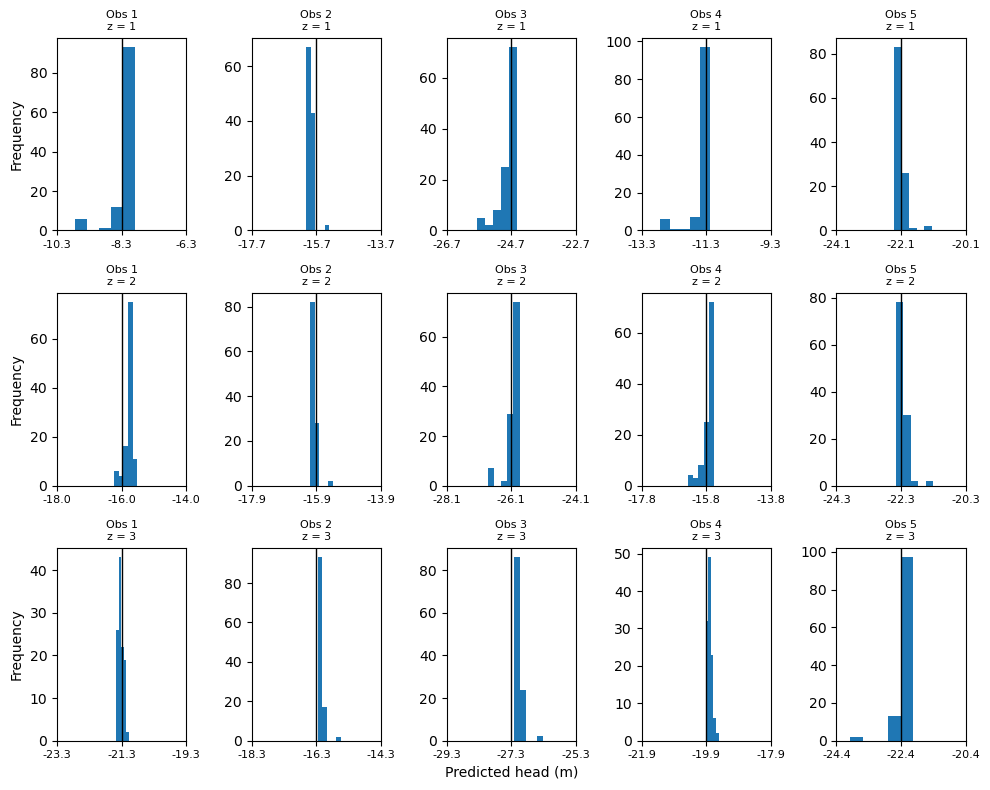

In [24]:
fig = plt.figure(figsize=(10,8))

for k in range(3): # OBS in z
    for j in range(5):  # OBS in xy
    
        ax = plt.subplot(3, 5, k * 5 + j + 1,aspect='auto')
        ax.set_title('Obs %i\nz = %i' %(j+1, k+1), size = 8)
        ax.hist(obs_future[:, j, k, -1], bins = 5)
        ax.axvline(ref_future[j, k, -1], lw = 1, color = 'black') # Plot truth
        if j == 0: ax.set_ylabel('Frequency', size = 10)
        if k == 2 and j ==2: ax.set_xlabel('Predicted head (m)', size = 10)
        ax.set_xlim([ref_future[j, k, -1] - 2, ref_future[j, k,-1] + 2])
        
        ax.set_xticks(ticks=[ref_future[j, k, -1] - 2, ref_future[j, k, -1], ref_future[j, k, -1] + 2], 
                      labels=[str(round(float(ref_future[j, k, -1] - 2),1)), 
                              str(round(float(ref_future[j, k, -1]),1)), 
                              str(round(float(ref_future[j, k, -1] + 2),1)),],
                      size = 8)
    
plt.subplots_adjust(wspace=0.4, hspace=0.4)    
plt.tight_layout()  
fig.savefig('../figures/figure8', dpi=450) 
plt.show()

### Plot reality vs predicted

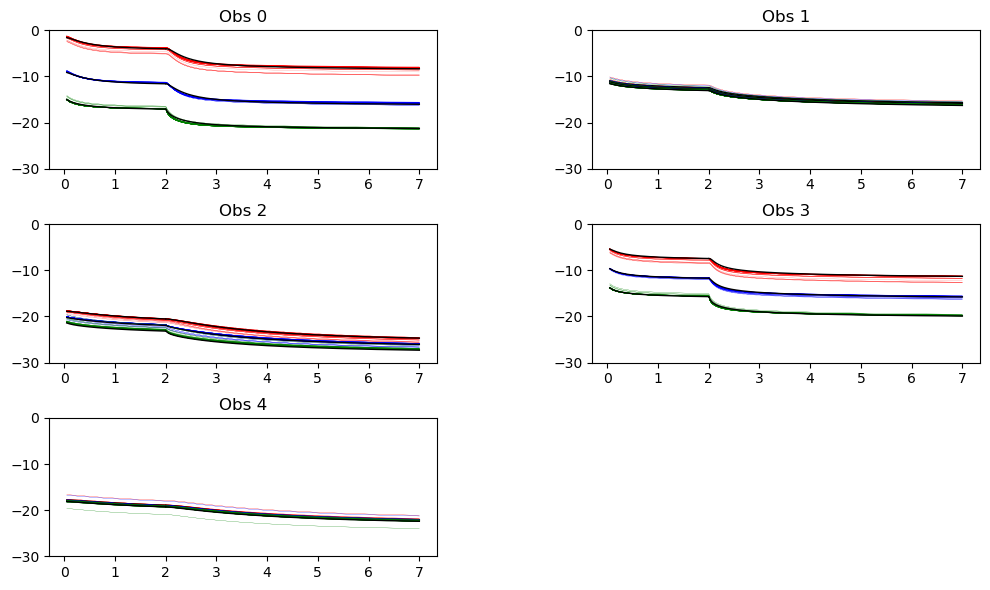

In [14]:
fig = plt.figure(figsize=(10,6))
#plt.suptitle(modelname, size = 14)
colors = ['red', 'blue','green']
for j in range(5):  # OBS in xy
    ax = plt.subplot(3, 2, j+1,aspect='auto')
    ax.set_title('Obs %i' %(j))
        
    for k in range(3): # OBS in z
        for i in range(len(obs_past)): 
            ax.plot(times_past, obs_past[i, j, k], '-', color = colors[k], lw = 0.1 ) 
            
        for i in range(len(obs_future)):
            ax.plot(times_future + 2, obs_future[i, j, k], '-', color = colors[k], lw = 0.1 ) 
        
        ax.plot(times_past, ref_past[j, k], lw = 1, color = 'black')#colors[k]) # Plot truth
        ax.plot(times_future+2, ref_future[j, k], lw = 1, color = 'black')# color = colors[k]) # Plot truth
    #if n > (nobs-4): 
    #    ax.set_xlabel('Time (years)', size = 10)
    #    ax.set_xticks(ticks=[0, 1, 2, 3, 4, 5], labels=[0, 1, 2, 3, 4, 5],size = 10)
    if n == 0 or n == 3 or n == 6: ax.set_ylabel('Head (m)', size = 10)
    #ax.axvline(2)
    ax.set_ylim([-30,0])
plt.tight_layout()    
plt.subplots_adjust(wspace=0.4, hspace=0.4)
plt.show()